In [22]:
pip install keras-tcn

In [23]:
# general
import numpy as np
import pandas as pd
import random
from google.colab import drive
from scipy.ndimage import gaussian_filter1d
# keras
from tcn import TCN
from keras.layers import Dense, Input, Lambda, concatenate, UpSampling1D, Attention, GRU
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *

#general
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import datetime
now = datetime.datetime.now
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error
from math import sqrt
# length of data sequences

# dimension of data sequences
n_dim = 88 # dimension after segmenting the data into body parts
batch_size = 2

In [24]:
import joblib

exercise = 'E1'
split_no = '4'

split_data_path = '/content/' + exercise + '_split_' + split_no + '.pkl'
split_data = joblib.load(split_data_path)

X_train = split_data['train']['data']
y_train = split_data['train']['labels']

X_test = split_data['test']['data']
y_test = split_data['test']['labels']

train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

test_x = X_test
test_y = y_test

In [25]:
import numpy as np

# Replace NaN values with mean in training data
nan_mask_train_X = np.isnan(X_train)
mean_values_train_X = np.nanmean(X_train)
X_train[nan_mask_train_X] = mean_values_train_X

nan_mask_train_y = np.isnan(y_train)
mean_values_train_y = np.nanmean(y_train)
y_train[nan_mask_train_y] = mean_values_train_y

# Replace NaN values with mean in testing data
nan_mask_test_X = np.isnan(X_test)
mean_values_test_X = np.nanmean(X_test)
X_test[nan_mask_test_X] = mean_values_test_X

nan_mask_test_y = np.isnan(y_test)
mean_values_test_y = np.nanmean(y_test)
y_test[nan_mask_test_y] = mean_values_test_y


print("The X_train size is ", X_train.shape)
print("The y_train size is ", y_train.shape)
print("The X_test size is ", X_test.shape)
print("The y_test size is ", y_test.shape)



def makeDataDivisibleBy8(myData):
    newData = []
    for file in myData:
      file_length = file.shape[0]
      new_length = file.shape[0]

      while (new_length % 8) != 0:
        new_length += 1
        print("New length is ", new_length)

      print("The desired length is ", new_length)

      rows_to_append = new_length - file_length

      zero_rows = np.zeros((rows_to_append, file.shape[1]))
      file = np.vstack([file, zero_rows])
      newData.append(file)

    print("The size after zero stacking is ", newData[0].shape)

    return np.array(newData)


train_x = makeDataDivisibleBy8(train_x)
valid_x = makeDataDivisibleBy8(valid_x)
test_x  = makeDataDivisibleBy8(test_x)

timesteps = train_x.shape[1]

The X_train size is  (120, 180, 132)
The y_train size is  (120,)
The X_test size is  (40, 180, 132)
The y_test size is  (40,)
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length is  183
New length is  184
The desired length is  184
New length is  181
New length is  182
New length i

In [26]:
# Reduce the data length by a factor of 2, 4, and 8
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
testx = test_x

trainx_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
validx_2 = np.zeros(trainx_2.shape)
testx_2 = np.zeros(trainx_2.shape)

trainx_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
validx_4 = np.zeros(trainx_4.shape)
testx_4 = np.zeros(trainx_4.shape)

trainx_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
validx_8 = np.zeros(trainx_8.shape)
testx_8 = np.zeros(trainx_8.shape)


trainx_2 = train_x[:,::2,:]
validx_2 = valid_x[:,::2,:]
testx_2 = test_x[:,::2,:]

trainx_4 = train_x[:,::4,:]
validx_4 = valid_x[:,::4,:]
testx_4 = test_x[:,::4,:]

trainx_8 = train_x[:,::8,:]
validx_8 = valid_x[:,::8,:]
testx_8 = test_x[:,::8,:]

In [27]:
def createTCNLayers(input, timesteps, n_dim):
    print('shape of input:: ', input.shape)

    tcn_layer = TCN(input_shape=(timesteps, n_dim), nb_filters=12,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',use_skip_connections=True,dropout_rate=0.05,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,use_weight_norm=False)(input)

    print('shape of tcn_layer: ', tcn_layer.shape)

    return tcn_layer

In [28]:
def getTCNLayers(input_f, input_2, input_4, input_8, timesteps, n_dim):

    print('--------------------------xxxx-----------------------------')
    tcn_1 = createTCNLayers(input_f, timesteps, n_dim)

    tcn_2 = createTCNLayers(input_2, timesteps, n_dim)
    #up_tcn_2 = UpSampling1D(size = 2)(tcn_2)
    print('tcn-2: ', tcn_2.shape)

    tcn_3 = createTCNLayers(input_4, timesteps, n_dim)
    #up_tcn_3 = UpSampling1D(size = 4)(tcn_3)
    print('tcn-3: ', tcn_3.shape)

    tcn_5 = createTCNLayers(input_8, timesteps, n_dim)
    #up-tcn_4 = UpSampling1D(size = 8)(tcn_4)
    print('tcn-5: ', tcn_5.shape)

    final_tcn = concatenate([tcn_1, tcn_2, tcn_3, tcn_5], axis=1)
    print('final_tcn: ', final_tcn.shape)
    print('--------------------------xxxx-----------------------------')

    return final_tcn

In [29]:
# Code to re-order the 132 dimensional skeleton data from the mediapipe sekeleton into trunk, left arm, right arm, left leg and right leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0],x.shape[1],16))
    X_left_arm = np.zeros((x.shape[0],x.shape[1],20))
    X_right_arm = np.zeros((x.shape[0],x.shape[1],20))
    X_left_leg = np.zeros((x.shape[0],x.shape[1],16))
    X_right_leg = np.zeros((x.shape[0],x.shape[1],16))

    X_trunk =  np.concatenate((x[:,:,44:52], x[:,:,92:100]), axis = 2)
    X_left_arm = np.concatenate((x[:,:,52:56], x[:,:,60:64], x[:,:,68:72], x[:,:,76:80], x[:,:,84:88]), axis = 2)
    X_right_arm = np.concatenate((x[:,:,56:60], x[:,:,64:68], x[:,:,72:76], x[:,:,80:84], x[:,:,88:92]), axis = 2)
    X_left_leg = np.concatenate((x[:,:,100:104], x[:,:,108:112], x[:,:,116:120], x[:,:,124:128]), axis = 2)
    X_right_leg = np.concatenate((x[:,:,104:108], x[:,:,112:116], x[:,:,120:124], x[:,:,128:132]), axis = 2)
    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg),axis = -1)
    return x_segmented


# Reorder the data dimensions to correspond to the five body parts
trainx =  reorder_data(train_x)
validx =  reorder_data(valid_x)
test_x =  reorder_data(test_x)

trainx_2 =  reorder_data(trainx_2)
validx_2 =  reorder_data(validx_2)
testx_2 = reorder_data(testx_2)

trainx_4 =  reorder_data(trainx_4)
validx_4 =  reorder_data(validx_4)
testx_4 = reorder_data(testx_4)

trainx_8 =  reorder_data(trainx_8)
validx_8 =  reorder_data(validx_8)
testx_8 = reorder_data(testx_8)

In [30]:
print(trainx.shape)
print(validx.shape)
print(test_x.shape)

print(trainx_2.shape)
print(validx_2.shape)
print(testx_2.shape)

print(trainx_4.shape)
print(validx_4.shape)
print(testx_4.shape)

print(trainx_8.shape)
print(validx_8.shape)
print(testx_8.shape)

(72, 184, 88)
(48, 184, 88)
(40, 184, 88)
(72, 92, 88)
(48, 92, 88)
(40, 92, 88)
(72, 46, 88)
(48, 46, 88)
(40, 46, 88)
(72, 23, 88)
(48, 23, 88)
(40, 23, 88)


In [31]:
n_dim = 88 # dimension after segmenting the data into body parts
n_dim1 = 16 # trunk dimension
n_dim2 = 20 # arms dimension
n_dim3 = 16 # legs dimension

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (timesteps, n_dim), name = 'full_scale')

seq_input_trunk = Lambda(lambda x: x[:, :, 0:16])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 17:36])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 37:56])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 57:72])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 73:88])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(timesteps/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:16])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 17:36])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 37:56])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 57:72])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 73:88])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(timesteps/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:16])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 17:36])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 37:56])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 57:72])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 73:88])(seq_input_4)

#### Eighth scale sequences
seq_input_8 = Input(shape=(int(timesteps/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:16])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 17:36])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 37:56])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 57:72])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 73:88])(seq_input_8)

concat_trunk = getTCNLayers(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8,
                            timesteps, n_dim1)
concat_left_arm = getTCNLayers(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8,
                               timesteps, n_dim2)
concat_right_arm = getTCNLayers(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8,
                               timesteps,n_dim2)
concat_left_leg = getTCNLayers(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8,
                               timesteps, n_dim3)
concat_right_leg = getTCNLayers(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8,
                               timesteps, n_dim3)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

tcn_layer_final = TCN(nb_filters=12,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8),
        padding='same',use_skip_connections=True,dropout_rate=0.05,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,
                      use_weight_norm=False)(concat)

tcn_layer_final_1 = TCN(nb_filters=8,kernel_size=2,nb_stacks=1,dilations=(1, 2, 4),
        padding='same',use_skip_connections=True,dropout_rate=0.05,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=True,use_layer_norm=False,
                        use_weight_norm=False)(tcn_layer_final)

tcn_layer_final_2 = TCN(nb_filters=6,kernel_size=3,nb_stacks=1,dilations=(1, 2),
        padding='same',use_skip_connections=True,dropout_rate=0.05,return_sequences=False,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,
                        use_weight_norm=False)(tcn_layer_final_1)

print('shape of tcn_layer_final: ', tcn_layer_final_2.shape)



out = Dense(1, activation = 'linear')(tcn_layer_final_2)

print('shape of out: ', out.shape)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)


--------------------------xxxx-----------------------------
shape of input::  (None, 184, 16)
shape of tcn_layer:  (None, 184, 12)
shape of input::  (None, 92, 16)
shape of tcn_layer:  (None, 92, 12)
tcn-2:  (None, 92, 12)
shape of input::  (None, 46, 16)
shape of tcn_layer:  (None, 46, 12)
tcn-3:  (None, 46, 12)
shape of input::  (None, 23, 16)
shape of tcn_layer:  (None, 23, 12)
tcn-5:  (None, 23, 12)
final_tcn:  (None, 345, 12)
--------------------------xxxx-----------------------------
--------------------------xxxx-----------------------------
shape of input::  (None, 184, 19)
shape of tcn_layer:  (None, 184, 12)
shape of input::  (None, 92, 19)
shape of tcn_layer:  (None, 92, 12)
tcn-2:  (None, 92, 12)
shape of input::  (None, 46, 19)
shape of tcn_layer:  (None, 46, 12)
tcn-3:  (None, 46, 12)
shape of input::  (None, 23, 19)
shape of tcn_layer:  (None, 23, 12)
tcn-5:  (None, 23, 12)
final_tcn:  (None, 345, 12)
--------------------------xxxx-----------------------------
----------

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 full_scale (InputLayer)     [(None, 184, 88)]            0         []                            
                                                                                                  
 half_scale (InputLayer)     [(None, 92, 88)]             0         []                            
                                                                                                  
 quarter_scale (InputLayer)  [(None, 46, 88)]             0         []                            
                                                                                                  
 eighth_scale (InputLayer)   [(None, 23, 88)]             0         []                            
                                                                                            

In [33]:
import tracemalloc
tracemalloc.start()
#create call backs
save_dir='/content/drive/My Drive/new_kimore/'
checkpoint = ModelCheckpoint(save_dir+'modelEX1.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')
# define our early stopping
early_stop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=70,
    verbose=1,
    mode='min',
    restore_best_weights=True)
callbacks_list = [early_stop, checkpoint]## This saves the best model

In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 75)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size=7, epochs=400, verbose=1,
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = callbacks_list)

print('Training time: %s' % (now() - t))

Epoch 1/400
11/11 [==============================] - ETA: 0s - loss: 7.4602
Epoch 1: val_loss improved from inf to 4.31796, saving model to /content/drive/My Drive/new_kimore/modelEX1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 277s 3s/step - loss: 7.4602 - val_loss: 4.3180
Epoch 2/400
11/11 [==============================] - ETA: 0s - loss: 0.8880
Epoch 2: val_loss improved from 4.31796 to 0.60663, saving model to /content/drive/My Drive/new_kimore/modelEX1.h5
11/11 [==============================] - 6s 585ms/step - loss: 0.8880 - val_loss: 0.6066
Epoch 3/400
11/11 [==============================] - ETA: 0s - loss: 0.6607
Epoch 3: val_loss improved from 0.60663 to 0.40828, saving model to /content/drive/My Drive/new_kimore/modelEX1.h5
11/11 [==============================] - 6s 585ms/step - loss: 0.6607 - val_loss: 0.4083
Epoch 4/400
11/11 [==============================] - ETA: 0s - loss: 0.5052
Epoch 4: val_loss did not improve from 0.40828
11/11 [==============================] - 3s 300ms/step - loss: 0.5052 - val_loss: 0.4479
Epoch 5/400
11/11 [==============================] - ETA: 0s - loss: 0.2865
Epoch 5: val_loss did not improve from 0.40828
11/11 [==========

In [35]:
print(tracemalloc.get_traced_memory())
# stopping the library
tracemalloc.stop()

(144457826, 146049195)


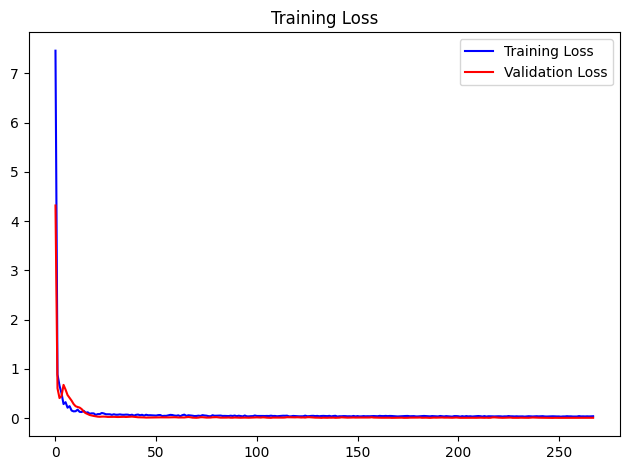

Training loss 0.03082830086350441
Validation loss 0.005251965951174498


In [36]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()
# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))

2/2 [==============================] - 13s 54ms/step


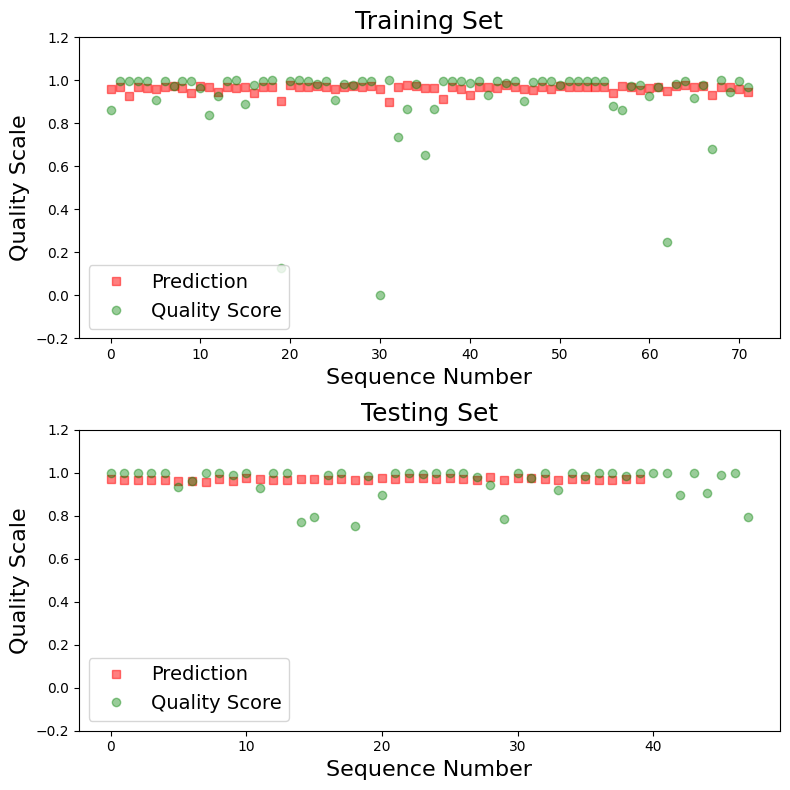

In [37]:
# Plot the prediction of the model for the training and validation sets
import tensorflow as tf
from keras.models import load_model
from keras.initializers import glorot_uniform
# Load the best model's weights
best_model = load_model('/content/drive/My Drive/new_kimore/modelEX1.h5', custom_objects={'TCN': TCN, 'GlorotUniform': glorot_uniform()})

pred_train = best_model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = best_model.predict([testx, testx_2, testx_4, testx_8])

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.2,1.2])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.2,1.2])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()

plt.show()

In [38]:
test_dev = abs(pred_test-test_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
#MSE
MSE=mean_squared_error(pred_test, test_y)
#MAPE
#P1 = 19*pred_test + 31;
#P2 = 19*test_y+31;
MAPE=np.mean(np.abs((pred_test-test_y)/test_y))*100
print('MSE:',MSE)
rms_dev = np.sqrt(mean_squared_error(pred_test, test_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)
print('MAPE:',MAPE)

MSE: 0.0012552409167820415
Mean absolute deviation: 0.02980398546800613
RMS deviation: 0.035429379288692615
MAPE: 3.1026335347060714
